In [6]:
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial#:~:text=when%20using%20matplotlib%3A-,Error%20%2315%3A%20Initializing%20libiomp5.,performance%20or%20cause%20incorrect%20results.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import numpy as np
from isochrones import get_ichrone

tracks = get_ichrone('mist', tracks=True)

def binary_color_mag_isochrones(
    m1,  # [Solar mass]
    q,   # m2/m1
    age=4.5, # [Gyr] 
    fe_h=0
):
    properties = tracks.generate_binary(
        m1,
        q * m1, 
        np.log10(age) + 9,  
        fe_h,
        bands=["G", "BP", "RP"]
    )
    b_mag = properties.BP_mag.values
    g_mag = properties.G_mag.values
    r_mag = properties.RP_mag.values
    return np.array([b_mag, g_mag, r_mag]).T[0]
    #return np.array([b_mag[0] - r_mag[0], g_mag[0]])



example = binary_color_mag_isochrones(1.0, 0.5)#4.5, -0.1)

print(example)


# Following https://www.mackelab.org/sbi/tutorial/00_getting_started/

from sbi import utils
from sbi import analysis
from sbi.inference.base import infer

[4.84525321 4.53204305 4.05122074]


In [7]:
print(f"Setting prior")
method = "SNPE"
labels = ("M1", "q", )#"age", "[M/H]")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.0,    1], # q
#    [0.1,    5], # age (Gyr)
#    [-1,   0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_samples = 10_000
num_simulations = 10_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(binary_color_mag_isochrones(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations
)

print(f"Creating observation")
truth = np.array([1.2, 0.75]) #3.5, -0.1])
observation = binary_color_mag_isochrones(*truth)
print(observation)

print(f"Sampling")
samples = posterior.sample(
    (num_samples,), 
    x=observation
)

print(f"Log probabilities..")
log_probability = posterior.log_prob(samples, x=observation)


Setting prior
Emulating posterior


Running 10000 simulations.: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:57<00:00, 175.25it/s]


 Neural network successfully converged after 116 epochs.Creating observation
[3.49150821 3.20676902 2.75820634]
Sampling


Drawing 10000 posterior samples: 10385it [00:00, 218038.89it/s]                                                                 

Log probabilities..


Plotting..


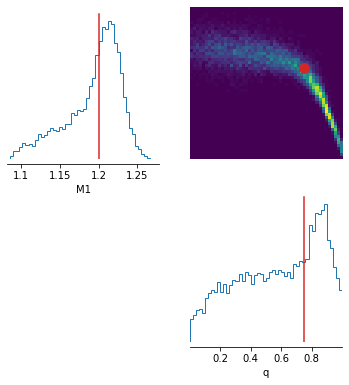

In [9]:
print("Plotting..")
fig, ax = analysis.pairplot(
    samples, 
    points=truth,
    #limits=bounds, 
    labels=labels,
    figsize=(6,6),
    points_colors=["tab:red"]
)

In [10]:
print(f"Setting prior")
method = "SNPE"
labels = ("M1", "q", "age", "[M/H]")
bounds = torch.tensor([
    [0.1,  1.8], # M1
    [0.0,    1], # q
    [0.1,    5], # age (Gyr)
    [-1,   0.5]  # metallicity
])
photometric_uncertainty_scale = 1e-4

num_samples = 10_000
num_simulations = 10_000

prior = utils.BoxUniform(low=bounds.T[0], high=bounds.T[1])

print(f"Emulating posterior")
def simulator(theta):
    z = torch.tensor(binary_color_mag_isochrones(*theta))
    return z + torch.randn(z.shape) * photometric_uncertainty_scale

posterior = infer(
    simulator, 
    prior, 
    method=method, 
    num_simulations=num_simulations
)

print(f"Creating observation")
truth = np.array([1.2, 0.75, 4.5, -0.1])
observation = binary_color_mag_isochrones(*truth)
print(observation)

print(f"Sampling")
samples = posterior.sample(
    (num_samples,), 
    x=observation
)

print(f"Log probabilities..")
log_probability = posterior.log_prob(samples, x=observation)


Setting prior
Emulating posterior


Running 10000 simulations.: 100%|████████████████████████████████████████████████████████| 10000/10000 [00:58<00:00, 172.12it/s]


 Neural network successfully converged after 221 epochs.Creating observation
[3.0866243  2.83775303 2.42922346]
Sampling


Drawing 10000 posterior samples: 10781it [00:00, 77175.84it/s]                                                                  


Log probabilities..


Plotting..


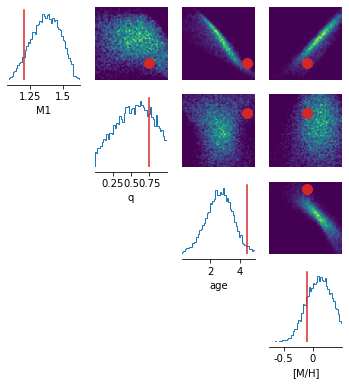

In [11]:
print("Plotting..")
fig, ax = analysis.pairplot(
    samples, 
    points=truth,
    labels=labels,
    figsize=(6,6),
    points_colors=["tab:red"]
)

In [14]:
A = binary_color_mag_isochrones(1.0, 0, 4.5, 0)
B = binary_color_mag_isochrones(1.0, 1, 4.5, 0)

In [20]:
A

array([4.85723285, 4.55370464, 4.08454103])

In [21]:
B

array([4.10465786, 3.80112965, 3.33196604])

In [25]:
A[0] - A[2]

0.7726918218614856

In [24]:
B[0] - B[2]

0.772691821861486